In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.0+cpu
0.17.0+cpu


* Let's import the code that we written in the previous section.

In [2]:
from modulers import data_setup, engine

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torchinfo import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cpu')

# 1. Get data
* We need to reload our data Pizza, Suchi, and Steak. to bbuild our transfer learning

In [6]:
import os
import requests
import zipfile
from pathlib import Path

# setup data
TARGET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
file_path = data_path / TARGET_URL.split("/")[-1]

if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download...")
    
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(file_path, "wb") as f:
        response = requests.get(TARGET_URL)
        print("Downloading pizza steak sushi data...")

        f.write(response.content)

    with zipfile.ZipFile(file_path, "r") as zip_ref:
        print("Unzipping pizza steak sushi data...")
        zip_ref.extractall(image_path)
        
    os.remove(file_path) # Remove the folder after unzipping it.

data\pizza_steak_sushi directory already exists, skipping download...


In [7]:
# setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2.Create dataset & DataLoader
* Now we have got some data, we want to turn it into PyTorch DataLoaders.
* To do so, we can use `data_setup.py` from `moduler` floder
* There is one thing we have to think about, how to **transform** the data?
    * 1. **Manually Created transformers:** you define what transformes you want your data.
    * 2. **Automatically Created transformers:** the transformed for your data are defiened by the model you would like to use.

## 2.1 Creating a transform for `torchvision.models` (manual creation).

In [8]:
from torchvision import transforms

from modulers import data_setup

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

batch_size = 32

train_loader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=batch_size
)


In [9]:
train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e77afb13d0>,
 ['pizza', 'steak', 'sushi'])

## 2.1 Creating a transform for `torchvision.models` (auto creation).

In [10]:
# Let's go to set the pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# get the transform
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
batch_size = 32

train_loader, test_loader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transform,
    batch_size=batch_size
)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e77afd6f10>,
 ['pizza', 'steak', 'sushi'])

# 3. Gitting a pretrained model 
There are a various places to get a pretrained model, such as:
1. Python domain libraries
2. Libraries like `timm` (torch image models)
3. Huggingface Hub
4. PaperwithCode

## 3.1 Which pretrained model should you used?
**Experiment, Experiment, Experiment!!🫠**
    

In [41]:
# Old method of creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 3.2 Getting summary of our model with `torchinfo.summary()`

In [42]:
sample = next(iter(train_loader))

In [43]:
summary(
    model,
    input_data=sample[0],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18
)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 224, 224]  [32, 1000]         --                 True
├─Sequential: 1-1                                       [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]  [32, 32, 112, 112] --                 True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]  [32, 32, 112, 112] 864                True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112] [32, 32, 112, 112] 64                 True
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [32, 32, 112, 112] [32, 16, 112, 112] --                 True
│    │    └─MBConv: 3-4                              

## 3.3 Freezing the base model and changing the output layer to suit our needs
* The trainable column will turn into `partial` instead of `trainable` after apply the freezing 

In [44]:
# 1. Freeze all of the base layer 
for param in model.features.parameters():
    param.requires_grad = False

In [45]:
print(f"Old classifier: {model.classifier}")

Old classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [46]:
# 2. update the clasifier head
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [47]:
print(f"New classifier: {model.classifier}")

New classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [48]:
summary(
    model,
    input_data=sample[0],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18
)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 224, 224]  [32, 3]            --                 Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

# 4. Train the model

In [49]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
from modulers.engine import train
from timeit import default_timer as timer

torch.manual_seed(42)

start = timer()

epochs = 15
results = train(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    epochs,
    device
)

end = timer()

print(f"[INFO] Total training time is: {end - start:.4f} s")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 0.4141, Train Loss: 1.0746 | Test acc: 0.7538, Test Loss: 0.8714
Epoch: 1 | Train acc: 0.7031, Train Loss: 0.8864 | Test acc: 0.7339, Test Loss: 0.8133
Epoch: 2 | Train acc: 0.8750, Train Loss: 0.7317 | Test acc: 0.8759, Test Loss: 0.6596
Epoch: 3 | Train acc: 0.7109, Train Loss: 0.7230 | Test acc: 0.9062, Test Loss: 0.6184
Epoch: 4 | Train acc: 0.8984, Train Loss: 0.5917 | Test acc: 0.7945, Test Loss: 0.6485
Epoch: 5 | Train acc: 0.8086, Train Loss: 0.5599 | Test acc: 0.8362, Test Loss: 0.5922
Epoch: 6 | Train acc: 0.8086, Train Loss: 0.5436 | Test acc: 0.8153, Test Loss: 0.6182
Epoch: 7 | Train acc: 0.8164, Train Loss: 0.4741 | Test acc: 0.8561, Test Loss: 0.5259
Epoch: 8 | Train acc: 0.9102, Train Loss: 0.4634 | Test acc: 0.8456, Test Loss: 0.5196
Epoch: 9 | Train acc: 0.8008, Train Loss: 0.5272 | Test acc: 0.8153, Test Loss: 0.5439
Epoch: 10 | Train acc: 0.9492, Train Loss: 0.4063 | Test acc: 0.8049, Test Loss: 0.5250
Epoch: 11 | Train acc: 0.9570, Train Loss:

# 5. Evaluate model

In [55]:
try:
    from helper_functions import plot_loss_curves
    
except:
    print(f"[INFO] Couldn't find helper_function.py, Downloading..")
    import requests
    
    TARGET_URL = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    
    response = requests.get(TARGET_URL)
    
    with open("helper_functions.py", "wb") as writer:
        writer.write(response.content)
        
    from helper_functions import plot_loss_curves

[INFO] Couldn't find helper_function.py, Downloading..


In [54]:
"target_url".upper()

'TARGET_URL'

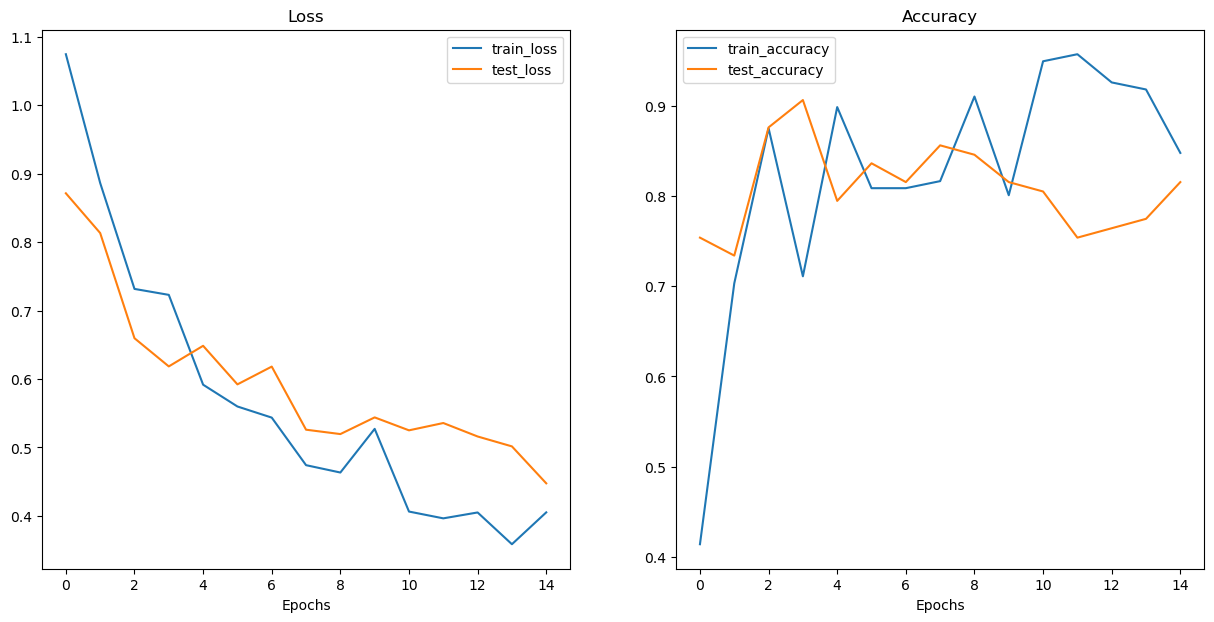

In [56]:
plot_loss_curves(results)

# 6. Make predictions on test images
* We have to make sure that our test/custom data is:
    1. **Same shape:** Images need to be same shape as model was trained on.
    2. **Same data type:** Custom data should be in the same data type.
    3. **Same device:** Custom/test data must be on the same device as the model.
    4. **Same transform:** If you transformed your data, ideally you will transform the test data and custom data the same.  To do all of this automatically, let's create a function called `pred_and_plot_image()`, that:
        1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
        2. Open the image with `PIL.Image.open()`.
        3. Create a transform if one doesn't exist.
        4. Make sure the model is on the target device.
        5. Turn the model to `model.eval()`mode to make sure it's ready for inference.
        6. Transform the target image and make sure its dimensionality is suited for thw model.
        7. Make a prediction on the by passing to the model.
        8. Convert the model's output logits to prediction probabilities using `torch.softmax()`.
        9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`.
        10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction from step 8.

In [103]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device
):
    # Load the image
    img = Image.open(image_path)
    
    # prepare the transformer
    if transform is not None:
        image_transform = transform
        
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # put the model on the target device
    model = model.to(device)
    
    # turn the model from training to eval
    model.eval()
    with torch.inference_mode():
        # transform the image and add more dim for the batch size
        transformed_image = image_transform(img).unsqueeze(dim=0)
        
        # Make prediction
        output = model(transformed_image.to(device))
        
    # convert logits to pred probs
    pred_probs = torch.softmax(output, dim=1)
    
    # convert pred probs to labels
    pred_labels = torch.argmax(pred_probs, dim=1)
    
    # plot the image
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred_labels.item()]} | Prob: {pred_probs.max().item():.3f}")
    plt.axis("off")

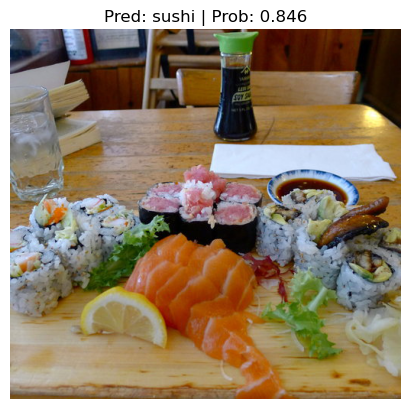

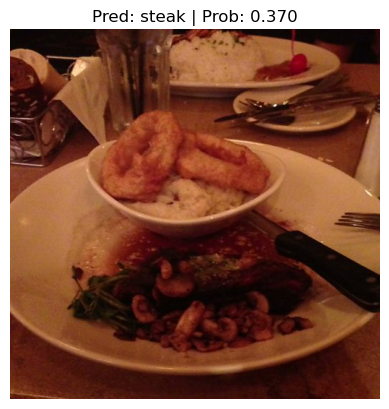

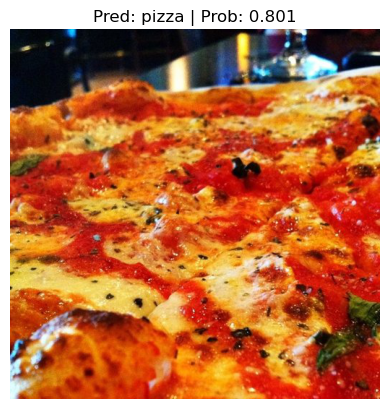

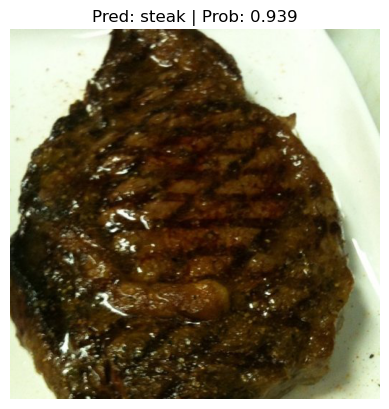

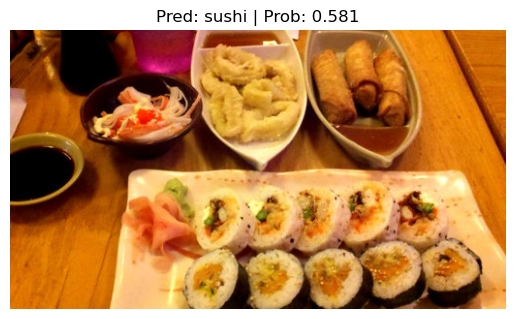

In [108]:
# Get a list of image paths from the test set
import random

number_random_image = 5
all_image_paths = list(test_dir.glob("*/*.jpg"))
random_sample_images = random.sample(all_image_paths, k=number_random_image)

for image_path in random_sample_images:
    pred_and_plot_image(
        model,
        class_names,
        image_path,
        (224, 224),
        auto_transform,
        device
    )